# Implementing a Deep Neural Network from scratch

Gilles Deknache Febuary 2024

This project has been assigned by Prof. Michal Madden as an assigment for the Deep Learning module at University of Galway. It consist of 5 part :
- Part 1 : Implementation of logistic regression which is the fundation of a neural network
- Part 2 : Testing a Blob and Circle dataset
- Part 3 : Implementation of a shallow neural network which is a neural network with only one layer
- Part 4 : Testing Fashion-MNIST data set, only selecting two classes
- Part 5 : Implement deep neural network which support any given structure and provide one further enhancement
    - I chose to Implement a multi-class classifier, adding the softmax function for the last layer
- Part 6 : testing on fashion-MNIST dataset for the 9 classes (I added this part)

Sources used in the project : 
- Prof. Michael Madden Lecture's slides
- Numpy documentation for dot product : https://numpy.org/doc/stable/reference/generated/numpy.dot.html  
and matmul : https://numpy.org/doc/stable/reference/generated/numpy.matmul.html
- previous knowledge of neural network and python so I did not use any external sources

## Part 1 : Implement logistic regression
Logistic regression is actually a binary classification algorithm and not a regression algorithm. It try to search for an optimal linear boundary line separating two class. It is basically a linear regressor with an activation function to compute the binary prediction

Logistic regression is the core component of a neural network. It can be also qualified as perceptron or a single node neural network.   

**NB :**  

The main difference between logistic regression and a perceptron is the activation function :
- Perceptron uses a step function (hard treshold)
- Logistic regression uses sigmoid function $\frac{^{1}}{1+e^{-x}}$ (soft threshold)

However The algorithm structure is the same : 

- Intialisation of parameters $w$ and $b$ (usually normal distribution)
- While the convergence criteria is not reached
    - Forward propagation $\hat{y} = f(w.x + b)$  where f is the activation function and . is a simple dot product
    - Compute the cost function $J = y*log(y) + (1-y)*log(y)$
    - Compute gradient of $J$ with respect to $w$ $Dw = (y-\hat{y})*x$
    - Gradient descent $w -= lr*Dw$ and $b -= lr*db$
    - Check for convergence


Implementation  detail :
- I choose to store the parameters in an numpy array which are handy for matrix multplication and vectorisation. 
- However for back propagation I did not use vectorisation so for a better understanding
- I tried to stay consistent with the following notation for my variable : 
    - `x` represent the input vector (single sample) and y its label
    -`J`cis the cost function calculated at each iteration of gradient descent
    - `w` is a weight vector of same lenght as `x`, `w[i]` correspond to the weight associated with the input `x[i]`
    - `b`is the bias
    - `DW[i]` and DB are the gradient of J with respect to `w[i]` and `b`

In [1]:
import numpy as np # array manipulation
import random as rd # randomness
import pandas as pd # dataframe manipulation
import matplotlib.pyplot as plt # ploting
from sklearn.metrics import accuracy_score,confusion_matrix # score metrics
import seaborn as sns # more visualisation

In [2]:
def sigmoid(x):
    """sigmoid function return 1 / (1 + e^-x)"""
    return 1/(1+np.exp(-x))

In [3]:
def logistic_regression(X,Y,lr = 0.001, max_iterations = 1000000,eps = 1e-4,mu = 0,sigma = 0.1):
    """
    X is training data, must ne numeric
    Y is the label, must be binary because we are doing binary classification
    lr is the learning rate of gradient descent
    max_iterations is the maximum number of iteration if convergence is not reached
    esp is thex treshold to check for convergence
    """

    # initialise parameters

    stopping = False
    J_running = 0
    J_running_prev = 0
    iteration = 0 
    J_list = []
    epoch = 0
    w = np.random.normal(mu,sigma,size=X.shape[1])
    b = np.random.normal(mu,sigma)
    N = len(X[:,1]) #number of sample in Training data

    # Convergence is not reached or max_iterations
    while not stopping:
        #Set {x, y} = single example from training set selected at random
        i = rd.randint(0,N-1)
        x,y = X[i],Y[i]
        # Forward propagation stage
        y_hat = sigmoid(np.dot(x,w) + b) 

        #Calculate J_current from y, y_hat
        J_current = - (y*np.log(y_hat + 1e-8) + (1-y)*np.log(1-y_hat+1e-8))

        DW = []
        DB = []
        # Back propagation
        for j in range(len(w)):
            DW.append((y_hat-y)*x[j])
            DB.append(y_hat-y)
        # Gradient descent 
        for j in range(len(w)):
            w[j] -= lr * DW[j]
            b -= lr * DB[j]

        # Check stopping criteria
        iteration += 1
        J_running += J_current
        if iteration > max_iterations: stopping = True 
        if (iteration % N) == 0: 
            epoch += 1 # epoch is updated when forward pass and backprop has been done on (approximately) all data
            J_running = J_running / N # Average of the cost function
            J_list.append(J_running) # update list at each epoch
            if abs(J_running - J_running_prev) < eps : stopping = True
            J_running_prev = J_running
            J_running = 0
            print(f'epoch {epoch} J = {J_running_prev}')

    # Print wether the convergence is reached or not
    if iteration == max_iterations+1:
        print("max iteration reached, convergence is not reached you may need to adjust parameters")
    else : 
        print(f"Training complete, convergence is reached after {epoch} epochs")
    
    
    return (J_list,w,b)

#### Testing

In [4]:
X = np.array([[2,3,4.89,0,1],
              [1,2,4,5,10]])
Y = np.array([0,1])
logistic_regression(X,Y);

epoch 1 J = 0.7730132363650868
epoch 2 J = 1.362994787733615
epoch 3 J = 1.321071591764008
epoch 4 J = 1.2805558538292665
epoch 5 J = 1.2413988279512926
epoch 6 J = 0.775174374625429
epoch 7 J = 0.7506027784718616
epoch 8 J = 1.2159415950740555
epoch 9 J = 1.5524952697171959
epoch 10 J = 1.1034561292496743
epoch 11 J = 1.0714051108500582
epoch 12 J = 1.0410613208733102
epoch 13 J = 1.0120753949910826
epoch 14 J = 0.9847659406974125
epoch 15 J = 0.958860915138769
epoch 16 J = 1.0240536071324324
epoch 17 J = 0.8880433785381373
epoch 18 J = 0.822016539075912
epoch 19 J = 0.8686768494756283
epoch 20 J = 0.7964001106664782
epoch 21 J = 0.849951988651071
epoch 22 J = 0.8305999127003478
epoch 23 J = 0.812299595036719
epoch 24 J = 0.7949851436823014
epoch 25 J = 0.744426369982535
epoch 26 J = 0.665782399734898
epoch 27 J = 0.819907487407558
epoch 28 J = 0.7235398533007598
epoch 29 J = 0.7113345978085099
epoch 30 J = 0.7893154884333149
epoch 31 J = 0.6973661093316699
epoch 32 J = 0.685766998522

## Part 2 : Easy tasks

### Blob dataset

In [5]:
blob = pd.read_csv('blobs400.csv')
X_blob = blob[['X1','X2','X3']]
Y_blob = blob['Class']
X_blob = X_blob.to_numpy()
Y_blob = Y_blob.to_numpy()

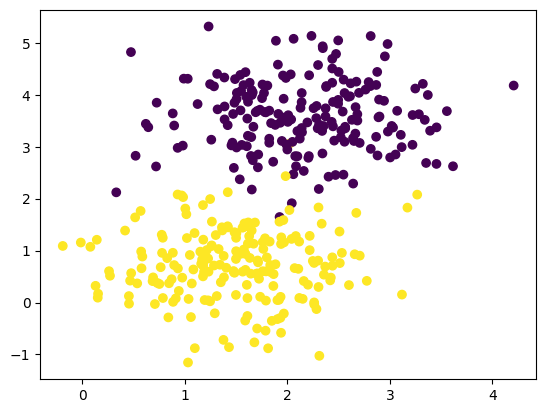

In [6]:
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=Y_blob, cmap='viridis');

In [7]:
def predict_logistic(X,w,b):
    """ forward pass for logistic regression and threshold for prediction """
    y_pred = sigmoid(np.dot(X,w) + b) 
    y_pred_binary = [1 if y > 0.5 else 0 for y in y_pred]
    return y_pred_binary

#### Train test split

Train 50 %  
Validation 25 %  
Test 25 %  

In [8]:
from sklearn.model_selection import train_test_split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_blob, Y_blob, test_size=0.5, random_state=42)
X_test_b, X_val_b, y_test_b, y_val_b = train_test_split(X_test_b, y_test_b, test_size=0.5, random_state=42)

#### Training

In [9]:
J_list,w,b = logistic_regression(X_train_b,y_train_b,lr = 0.001,eps = 1e-6,max_iterations=1000000)

epoch 1 J = 0.6699968412315522
epoch 2 J = 0.5945505082262267
epoch 3 J = 0.535807604365474
epoch 4 J = 0.5065553071919872
epoch 5 J = 0.47155556404592697
epoch 6 J = 0.4461822174654243
epoch 7 J = 0.42962371040001784
epoch 8 J = 0.4017474809411843
epoch 9 J = 0.4067691112532356
epoch 10 J = 0.38128931856869935
epoch 11 J = 0.3865001145280686
epoch 12 J = 0.3792798569014559
epoch 13 J = 0.3419055063435307
epoch 14 J = 0.35150877656539953
epoch 15 J = 0.3147435742718182
epoch 16 J = 0.32870565911594896
epoch 17 J = 0.3222141495451352
epoch 18 J = 0.28919482324428325
epoch 19 J = 0.27569974949071613
epoch 20 J = 0.29813091682562964
epoch 21 J = 0.289084544774804
epoch 22 J = 0.266688214784178
epoch 23 J = 0.2907850747349421
epoch 24 J = 0.24572331417263185
epoch 25 J = 0.26828590874486274
epoch 26 J = 0.26169780177426333
epoch 27 J = 0.24084721163124392
epoch 28 J = 0.23977279803077625
epoch 29 J = 0.23920408342232777
epoch 30 J = 0.23037399765833474
epoch 31 J = 0.25149398604354856
epoc

epoch 58 J = 0.17275572413095103
epoch 59 J = 0.16763744069421482
epoch 60 J = 0.17881880484036666
epoch 61 J = 0.18400813555798887
epoch 62 J = 0.1485981687948005
epoch 63 J = 0.15852445742887106
epoch 64 J = 0.1647743858344956
epoch 65 J = 0.15743370121958436
epoch 66 J = 0.1572427559275861
epoch 67 J = 0.12660494544021372
epoch 68 J = 0.15176527440540177
epoch 69 J = 0.1441800366988237
epoch 70 J = 0.14664978793291591
epoch 71 J = 0.15516617449009218
epoch 72 J = 0.1600055889619243
epoch 73 J = 0.1322173870163068
epoch 74 J = 0.1560088613442048
epoch 75 J = 0.14448804106408564
epoch 76 J = 0.1346663684143123
epoch 77 J = 0.1292483207550988
epoch 78 J = 0.15341495815825704
epoch 79 J = 0.14629923068538825
epoch 80 J = 0.1455514736669727
epoch 81 J = 0.1250618621023787
epoch 82 J = 0.12747668166759304
epoch 83 J = 0.14387628383006423
epoch 84 J = 0.12413648093337967
epoch 85 J = 0.12761245612605343
epoch 86 J = 0.1459057938850673
epoch 87 J = 0.1374303769841485
epoch 88 J = 0.13145480

#### Learning curve

Text(0.5, 1.0, 'Learning curve')

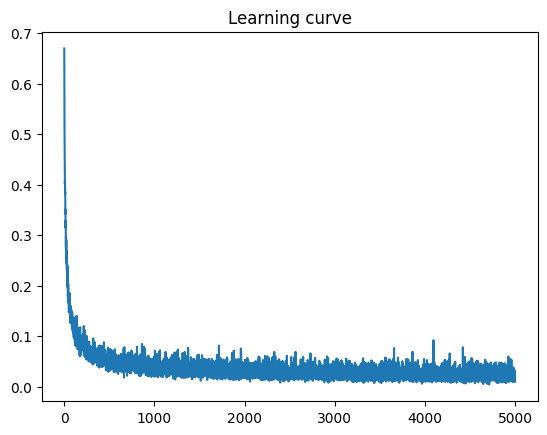

In [10]:
import matplotlib.pyplot as plt
plt.plot(J_list)
plt.title("Learning curve")

Note on the training curve:
- Parameter initialisation impact
    - for `mu = 0` and `nu = 1` I have faster convergence but each time I re-run the algorithm I have a different learning curve shape
    - for `mu = 0` and `nu = 0.1` I have more epoch but always the same learning curve shape, so there is less variability
- Learning rate impact : 
    - for `lr = 0.1` we observe unstability and convergence is not reached after 1 milion iteration
    - for `lr = 0.001` convergence is reached but there is still some unstability 

I choose to keep `nu = 0.1` for the rest of the assigment to have good reproducability and less variability between the results (we could also set a random seed)  
The unstability may be explained by the fact that stochastic gradient descent is stochastic so the gradient may not be accurate there for the parameters can "zig zag" their way through the optimal solution

#### Validation

In [11]:
# Validation
from sklearn.metrics import accuracy_score
y_pred = predict_logistic(X_val_b,w,b)
acc = accuracy_score(y_pred,y_val_b)
print(f'Validation accuracy score : {acc: .3f}')

Validation accuracy score :  0.960


Experiments : 
- `lr = 0.001 and eps = 1e-6 `--> 0.960
- `lr = 0.001 and eps = 1e-7` --> O.960 but convergence is not reached
- `lr = 0.0005, eps = 1e-6` --> 0.960 but convergence is not reached
- `lr = 0.0005, eps = 1e-6 max_iterations = 10 millions` --> 0.950 and convergence is reached --> overfitting !

Based on these experiments on the validation set I will set the parameter to lr = 0.001, eps = 1e-6 and max_iteration = 1 million for the test set

#### Test

In [12]:
# Train on train + validation set 
X_train_b_tot = np.concatenate((X_train_b, X_val_b), axis=0)
y_train_b_tot = np.concatenate((y_train_b, y_val_b), axis=0)
J_list,w,b = logistic_regression(X_train_b_tot,y_train_b_tot,lr = 0.001,eps = 1e-6,max_iterations=1000000)

epoch 1 J = 0.6515338612781498
epoch 2 J = 0.5735222641861931
epoch 3 J = 0.5401318895548541
epoch 4 J = 0.47563478998155984
epoch 5 J = 0.4466850313249686
epoch 6 J = 0.43440118638384084
epoch 7 J = 0.40353582815078076
epoch 8 J = 0.3762379494221713
epoch 9 J = 0.3535625833015041


epoch 10 J = 0.3556394981417517
epoch 11 J = 0.34762836585861084
epoch 12 J = 0.3169033919253875
epoch 13 J = 0.2992027857877301
epoch 14 J = 0.3287491896794424
epoch 15 J = 0.2795821527328293
epoch 16 J = 0.27350695460127594
epoch 17 J = 0.27086688250016
epoch 18 J = 0.25965468948276565
epoch 19 J = 0.28716090991101234
epoch 20 J = 0.27285549321759545
epoch 21 J = 0.2535518396866942
epoch 22 J = 0.23306323876335658
epoch 23 J = 0.23386640210509535
epoch 24 J = 0.23887519907058993
epoch 25 J = 0.23026884611119106
epoch 26 J = 0.21320899939145024
epoch 27 J = 0.20978223466465126
epoch 28 J = 0.21509881100738043
epoch 29 J = 0.22066722107192172
epoch 30 J = 0.23036626115227804
epoch 31 J = 0.19515629666323964
epoch 32 J = 0.18279134733695096
epoch 33 J = 0.20296756640947305
epoch 34 J = 0.18699264077057384
epoch 35 J = 0.1873650815048172
epoch 36 J = 0.17939432938305003
epoch 37 J = 0.18150314177958107
epoch 38 J = 0.1726047725132425
epoch 39 J = 0.1830052536514991
epoch 40 J = 0.1829658

We see that convergence is not reached but I won't increase the max_iterations to avoid overfitting

In [13]:
y_pred = predict_logistic(X_test_b,w,b)
acc = accuracy_score(y_pred,y_test_b)
print(f'Test accuracy score : {acc: .3f}')

Test accuracy score :  0.980


The accuracy is not equal to 1 because data has been generated with noise, therefore it is not perfeclty linearly seperable. However the result is very close to 1 so algorithm is working good.

#### Visualisation of the result

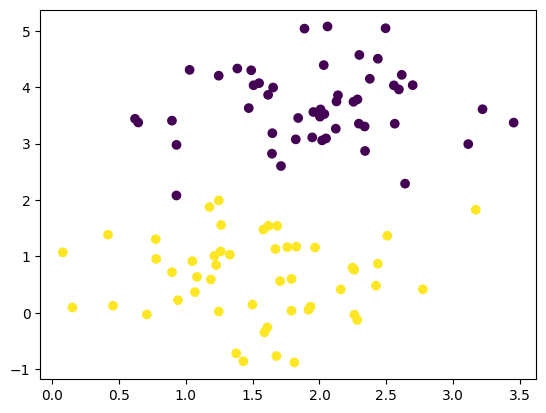

In [14]:
plt.scatter(X_test_b[:, 0], X_test_b[:, 1], c=y_pred, cmap='viridis');

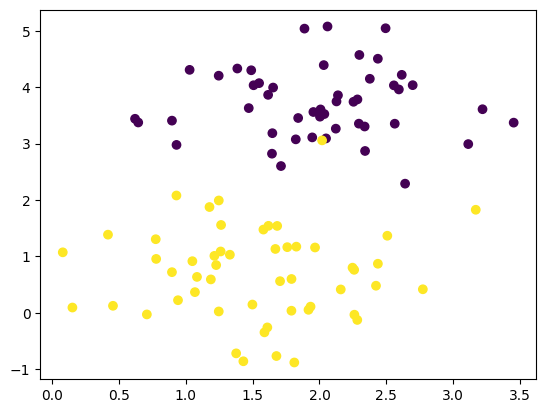

In [15]:
plt.scatter(X_test_b[:, 0], X_test_b[:, 1], c=y_test_b, cmap='viridis');

We can see here one yellow point that is not linearly separate from the other class ( at least on this 2 dimensions) so the algorithm is missclassifying it

### Circle dataset

I will use the same methodology for this dataset

In [16]:
circle = pd.read_csv('circles500.csv')
X_circle = circle[['X0','X1']]
Y_circle = circle[['Class']]
X_circle = X_circle.to_numpy()
Y_circle = Y_circle.to_numpy()
Y_circle = Y_circle.reshape(500)

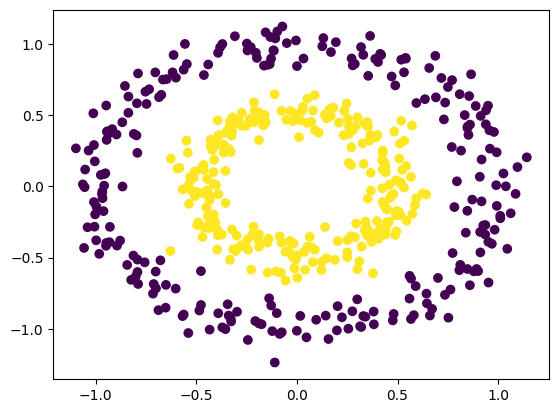

In [17]:
plt.scatter(X_circle[:, 0], X_circle[:, 1], c=Y_circle, cmap='viridis');

In [18]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_circle, Y_circle, test_size=0.7, random_state=42)
X_test_c, X_val_c, y_test_c, y_val_c = train_test_split(X_test_c, y_test_c, test_size=0.5, random_state=42)

In [19]:
J_list,w,b = logistic_regression(X_train_c,y_train_c,lr = 0.001,eps =1e-4,max_iterations=1000000,sigma = 2)

epoch 1 J = 1.9397584581931069
epoch 2 J = 2.10311526996425
epoch 3 J = 1.6020212673550411
epoch 4 J = 1.7648642334713205
epoch 5 J = 1.6141178748969993
epoch 6 J = 1.5560231520805392
epoch 7 J = 1.595688646805351
epoch 8 J = 1.448962844916286
epoch 9 J = 1.3505110231229047
epoch 10 J = 1.6717667133067358
epoch 11 J = 1.473764765756151
epoch 12 J = 1.3655795646786155
epoch 13 J = 1.2026857559967803
epoch 14 J = 1.3528806586612314
epoch 15 J = 1.3260280251257093
epoch 16 J = 1.1655661249951892
epoch 17 J = 1.1864778627783317
epoch 18 J = 1.2561000316026496
epoch 19 J = 1.1929952934508377
epoch 20 J = 1.1471538358834337
epoch 21 J = 1.0625023766376702
epoch 22 J = 1.1303898115496058
epoch 23 J = 1.2297898180278906
epoch 24 J = 0.9339229866515553
epoch 25 J = 0.9279058009049926
epoch 26 J = 1.1336139451151623
epoch 27 J = 1.0571800396606539
epoch 28 J = 0.9317175333950112
epoch 29 J = 0.8932449662317331
epoch 30 J = 1.0316442643088215
epoch 31 J = 1.0013411670256571
epoch 32 J = 0.8944123

Text(0.5, 1.0, 'Learning curve')

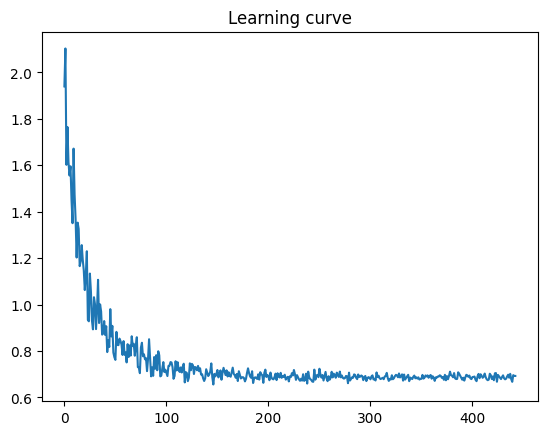

In [20]:
plt.plot(J_list)
plt.title("Learning curve")

#### Notes 
- I had to set `sigma = 2` to observe the learning curve  by adding artificially some error at the inittialisation
- Every parameter setting leads to poor result because the data is not linearly seperable
- Therefore, I will not perform parameter tuning

In [21]:
y_pred = predict_logistic(X_val_c,w,b)
acc = accuracy_score(y_pred,y_val_c)
print(f'Validation score : {acc: .3f}')

Validation score :  0.394


In [22]:
y_pred = predict_logistic(X_test_c,w,b)
acc = accuracy_score(y_pred,y_test_c)
print(f'Test Accuracy score : {acc: .3f}')

Test Accuracy score :  0.314


#### Visualisation

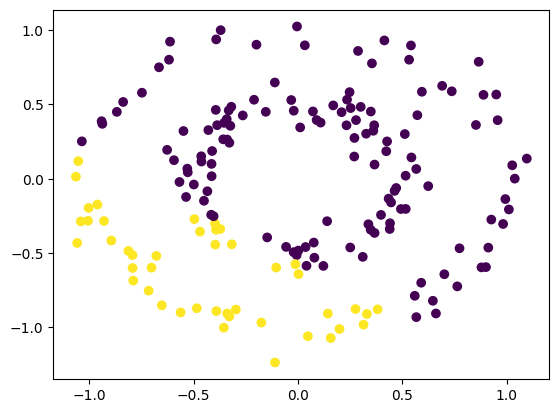

In [24]:
plt.scatter(X_test_c[:, 0], X_test_c[:, 1], c=y_pred, cmap='viridis');

We can see that the algorithm try to separate the data with a straight line but the circle data is not linearly separable

## Part 3

Shallow neural net is a neural network with only two layer. The implementation will only include binary classification.  
It works similarly than logistic regression but with a more complex structure which will be able to learn non-linear patterns.

Initialisation of parameters :   
there is now 2 layer so we need to store 2 weight matrix and and 2 bias vector :   
$W^{1}$ which is the weight matrix  of the hidden state of shape `(n_nodes,input_nodes)`  
$W^{2}$ which is the weight matrix of the output layer of shape `(1,n_nodes)`

Forward propagation consist now 2 steps : 
1. propagating the signal to all neurons in the hidden layer and then apply an activation function (sigmoid) to each neurons.  
    - $z^{[1]} = W^{[1]}.x + b^{[1]}$
    - $a^{[1]} = sigmoid(z^{[1]})$
    - $z^{[2]} = W2  a^{[1]} + b^{[2]}$
    - $a^{[2]} = sigmoid(z^{[2]})$
    - $\hat{y} = a^{[2]}_{0}$
    - $J = - (y*log(\hat{y}) + (1-y)*log(1-\hat{y}))$
2. propagating the signal to the output layer combining the result of the input layer and compute the final prediction $\hat{y}$

Back propagation consist also of two step :
1. computing all the gradient for the output layer : 
    - Compute gradient of J with respect to z which is $\hat{y} - y$
    - multiply  by the gradient of z with respect to $W^{[2]}$ which is $a^{[1]}$
    - Overall : $DW^{[2]} = (\hat{y} - y)*a^{[1]}$
    - same for b, detail in the code
2. computing the gradient for the hidden layer : 
    - detail in the code

Gradient decsent stay the same : $W -= lr*DW$ and $b -= lr*db$


implementation detail : 
- I reused the code of logistic regression and made some modification to make it as close as possible to the previous formula.  
- I used 4 differents numpy arrays to store the parameter in each of the two layer. 
- The first issue I faced is related to the dimension of those vectors, I had to really understand the architecture to make it work.
- for forward propagation I used vectorisation with matrix multiplication `z1 = W1*x + b1` and `z2 = W2*a1 + b2`. But I had to figure out that we have to transpose `a1` to have the right matrix shape for multiplication.
- I did not use vectorisation for backprop because I understand it better and it is closer to the formulas I know

In [25]:
def dsigmoid(x):
    """ derivative of the sigmoid function"""
    return sigmoid(x)*(1-sigmoid(x))

In [26]:
def shallowNeuralNet(X,Y,n_nodes,lr = 0.001, max_iterations = 1000000,eps = 1e-4,nu = 0, sigma = 0.1):
    stopping = False
    # initialize parameters
    W1 = np.random.normal(nu,sigma,size=(n_nodes,X.shape[1]))
    b1 = np.random.normal(nu,sigma,size=(1,n_nodes))
    W2 = np.random.normal(nu,sigma,size=(1,n_nodes))
    b2 = np.random.normal(nu,sigma)

    N = len(X[:,1])
    J_running = 0
    J_running_prev = 0
    iteration = 0 
    J_list = []
    epoch = 0
    while not stopping: 
        i = rd.randint(0,N-1)
        x,y = X[i],Y[i]
        x = x.T
        # forward propagation 
        z1 = W1 @ x + b1
        a1 = sigmoid(z1) 
        z2 = W2 @ a1.T + b2
        a2 = sigmoid(z2)
        y_hat = a2[0,0]
        J_current = - (y*np.log(y_hat + 1e-8) + (1-y)*np.log(1-y_hat + 1e-8))

        # Backpropagation

        # output layer 
        dz2  = y_hat - y
        dW2 = dz2*a1
        db2 = dz2
      
        # Hidden Layer 
        dz1 = []
        for i in range(n_nodes): 
            dz1.append(dsigmoid(z1[0,i]) * dz2 * W2[0,i])
        
        dW1 = np.zeros((n_nodes,X.shape[1]))
        db1 = np.zeros((1,n_nodes))

        for j in range(n_nodes):
            db1[0,j] = dz1[j]
            for i in range(X.shape[1]):
                dW1[j,i] = dz1[j] * x[i]
                

        # Update weight with gradient descent : 
        W1 -= lr * dW1
        b1 -= lr * db1
        W2 -= lr*dW2
        b2 -= lr*db2

        
    

        # Check stopping criteria
        iteration += 1
        J_running += J_current
        if iteration > max_iterations: stopping = True 
        if (iteration % N) == 0: 
            epoch += 1
            J_running = J_running / N
            J_list.append(J_running)
            if abs(J_running - J_running_prev) < eps : stopping = True
            print(f'epoch {epoch} J = {J_running}')
            J_running_prev = J_running
            J_running = 0
            

    # Print wether the convergence is reached or not
    if iteration == max_iterations + 1:
        print("max iteration reached, convergence is not reached you may need to adjust parameters")
    else : 
        print(f"Training complete, convergence is reached after {epoch} epochs")
    return (J_list,W1,W2,b1,b2)

In [27]:
def predict_shallowNN(X,W1,W2,b1,b2):
    y_pred = []
    for i in range(len(X[:,1])):
        x = X[i]
        z1 = W1 @ x + b1
        a1 = sigmoid(z1) 
        z2 = W2 @ a1.T + b2
        a2 = sigmoid(z2)
        y_hat = a2[0,0]
        y_pred.append(y_hat)
    y_pred_binary = [1 if y > 0.5 else 0 for y in y_pred]
    return y_pred_binary

#### blob dataset 

In [28]:
n_nodes = 5
J_list,W1,W2,b1,b2 = shallowNeuralNet(X_train_b,y_train_b,n_nodes,eps = 1e-6,lr = 0.001,sigma=0.1,max_iterations=150000)

epoch 1 J = 0.7080648994858231
epoch 2 J = 0.6950583489763986
epoch 3 J = 0.692466149758537
epoch 4 J = 0.7005366969080176
epoch 5 J = 0.6946270253558764
epoch 6 J = 0.6903465690662983
epoch 7 J = 0.6929773659595897
epoch 8 J = 0.6899251917445473
epoch 9 J = 0.6888761731054842
epoch 10 J = 0.687467413617533
epoch 11 J = 0.6862486328557351


epoch 12 J = 0.6860803530620153
epoch 13 J = 0.6859671206425717
epoch 14 J = 0.6838229133049212
epoch 15 J = 0.6834093370541886
epoch 16 J = 0.6828410336489451
epoch 17 J = 0.6803392710943554
epoch 18 J = 0.6814103698409183
epoch 19 J = 0.6790518683269735
epoch 20 J = 0.6759053841082617
epoch 21 J = 0.6781701963866853
epoch 22 J = 0.6769561626703545
epoch 23 J = 0.6743955564076188
epoch 24 J = 0.6746373529599545
epoch 25 J = 0.673370774667657
epoch 26 J = 0.6741947242709588
epoch 27 J = 0.672597787125595
epoch 28 J = 0.6691105529566741
epoch 29 J = 0.6690196002922238
epoch 30 J = 0.6652414491195034
epoch 31 J = 0.6641826022808452
epoch 32 J = 0.6674837984017293
epoch 33 J = 0.662763825343218
epoch 34 J = 0.6625149281731221
epoch 35 J = 0.6622366388406968
epoch 36 J = 0.6557266043854095
epoch 37 J = 0.65817849604273
epoch 38 J = 0.6574224013238217
epoch 39 J = 0.6485435507814746
epoch 40 J = 0.6470592375011742
epoch 41 J = 0.6541341851768167
epoch 42 J = 0.6478343930204202
epoch 43 J = 

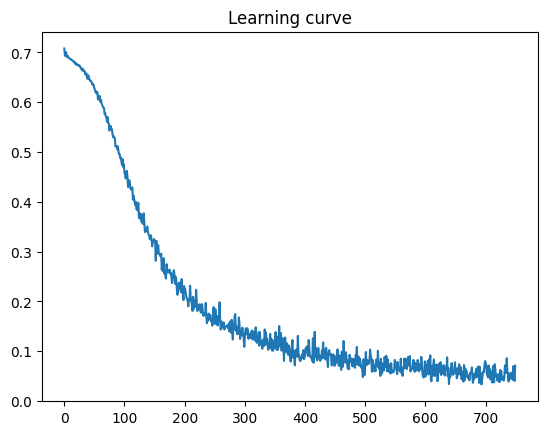

In [29]:
plt.plot(J_list)
plt.title("Learning curve");

In [30]:
y_pred = predict_shallowNN(X_val_b,W1,W2,b1,b2)
acc = accuracy_score(y_pred,y_val_b)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.960


Experiment : 
- `n_nodes = 1,eps = 1e-6,lr = 0.001,max_iterations=1million` --> convergence is reached after 7884 epochs, accuracy of 0.94, may overfit, reduce the max_iteration
- `n_nodes = 1,eps = 1e-6,lr = 0.001,max_iterations= 500 000` --> convergence not reached, accuracy of 0.95, increase number of nodes
- `n_nodes = 2,eps = 1e-6,lr = 0.001,max_iterations= 500 000` --> convergence not reached accuracy of 0.95. increase number of nodes
- `n_nodes = 5,eps = 1e-6,lr = 0.001,max_iterations= 500 000` --> still 0.95, decrease max_iteration
- `n_nodes = 5,eps = 1e-6,lr = 0.001,max_iterations= 150 000` --> still 0.95

It seems like I can not improve 0.95 which is less than logistic regression 0.96. I can select any setting

In [31]:
## train on train + validation
J_list,W1,W2,b1,b2 = shallowNeuralNet(X_train_b_tot,y_train_b_tot,n_nodes,eps = 1e-6,lr = 0.001,sigma=0.1,max_iterations=500000)

epoch 1 J = 0.6934927564932297
epoch 2 J = 0.6926527085711525
epoch 3 J = 0.6918009863596092
epoch 4 J = 0.6903625353477222
epoch 5 J = 0.6906456663785405
epoch 6 J = 0.6890023727196141
epoch 7 J = 0.6877891871934432
epoch 8 J = 0.686906919055489
epoch 9 J = 0.6854297093422113
epoch 10 J = 0.6834170170454715
epoch 11 J = 0.6818995781902932
epoch 12 J = 0.6831279633277721
epoch 13 J = 0.6796464668546146
epoch 14 J = 0.6776201556501128
epoch 15 J = 0.6761924374758896
epoch 16 J = 0.6758158218079605
epoch 17 J = 0.6757851154305199
epoch 18 J = 0.6717496553125372
epoch 19 J = 0.669297821049594
epoch 20 J = 0.6672651625759352
epoch 21 J = 0.6639968774451473
epoch 22 J = 0.6624852129376015
epoch 23 J = 0.6577565649010123
epoch 24 J = 0.6573897284058504
epoch 25 J = 0.6550304628693382
epoch 26 J = 0.6516349666046444
epoch 27 J = 0.645925498252823
epoch 28 J = 0.6434847279580387
epoch 29 J = 0.6448780866206202
epoch 30 J = 0.6360879679951504
epoch 31 J = 0.6348098812208801
epoch 32 J = 0.63315

In [32]:
y_pred = predict_shallowNN(X_test_b,W1,W2,b1,b2)
acc = accuracy_score(y_pred,y_test_b)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.980


I got 0.98 which is less than 0.99 in logistic regression. 


**Conclusion** : for the blob data set complex model is not needed, logistic regression is enough !

#### Circle dataset

In [33]:
n_nodes = 10
J_list,W1,W2,b1,b2 = shallowNeuralNet(X_train_c,y_train_c,n_nodes,lr = 0.001,eps = 1e-8,max_iterations=3000000)

epoch 1 J = 0.6954783134654421
epoch 2 J = 0.6933162078055346
epoch 3 J = 0.6889441796901261
epoch 4 J = 0.6899811803949438
epoch 5 J = 0.6875184673747446
epoch 6 J = 0.6925606749641482
epoch 7 J = 0.679998491695832
epoch 8 J = 0.6882640902650908
epoch 9 J = 0.6924766910572476
epoch 10 J = 0.6926049062921961
epoch 11 J = 0.6903433742913778
epoch 12 J = 0.6901926074599282
epoch 13 J = 0.6880956804679771
epoch 14 J = 0.6808135853424317
epoch 15 J = 0.69150870542452
epoch 16 J = 0.6926585027860104
epoch 17 J = 0.6902001655912707
epoch 18 J = 0.6913978437854068
epoch 19 J = 0.6835061002901461
epoch 20 J = 0.6913962950849706
epoch 21 J = 0.6937469305709318
epoch 22 J = 0.6916106017088669
epoch 23 J = 0.689094676519196
epoch 24 J = 0.6891063183724037
epoch 25 J = 0.6955369285633347
epoch 26 J = 0.6950843025999714
epoch 27 J = 0.6835280810052609
epoch 28 J = 0.7055429863760293
epoch 29 J = 0.6934352560110721
epoch 30 J = 0.6905782849109714
epoch 31 J = 0.6944698836148308
epoch 32 J = 0.693810

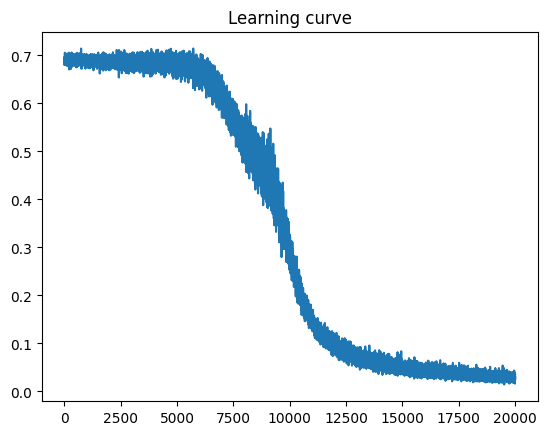

In [34]:
plt.plot(J_list)
plt.title("Learning curve");

- Take a long time before decreasing, therefore i will lower the treshold to avoid stopping to early

In [35]:
y_pred = predict_shallowNN(X_val_c,W1,W2,b1,b2)
acc = accuracy_score(y_pred,y_val_c)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.994


Experiment : 
- `n_nodes = 5,lr = 0.001,eps = 1e-7,max_iterations=1000000` -->  takes a long time to decrease, convergence not reached, accuracy = 0.912, increase the number of iterations  
- `n_nodes = 5,lr = 0.001,eps = 1e-8,max_iterations=2000000` --> 0.977, let's increase max_iteration again   
- `n_nodes = 5,lr = 0.001,eps = 1e-8,max_iterations= 3000000` --> 0.989, better, lets increase again 
- `n_nodes = 5,lr = 0.001,eps = 1e-8,max_iterations= 5000000` --> 0.977, slighly overfit, lets increase the number of nodes
- `n_nodes = 10,lr = 0.001,eps = 1e-8,max_iterations= 3000000` --> 0.977


Best model found : `n_nodes = 5,lr = 0.001,eps = 1e-8,max_iterations= 3000000`

In [36]:
# train on train + validation
X_train_c_tot = np.concatenate((X_train_c, X_val_c), axis=0)
y_train_c_tot = np.concatenate((y_train_c, y_val_c), axis=0)
J_list,W1,W2,b1,b2 = shallowNeuralNet(X_train_c_tot,y_train_c_tot,n_nodes=5,lr = 0.001,eps = 1e-8,max_iterations=3000000)

epoch 1 J = 0.6938859996212339
epoch 2 J = 0.6881080999662497
epoch 3 J = 0.6921108663365856
epoch 4 J = 0.6938632078339081
epoch 5 J = 0.69211302193899
epoch 6 J = 0.6936253332198531
epoch 7 J = 0.6925245493642869
epoch 8 J = 0.6914194874692048
epoch 9 J = 0.6894363478318973
epoch 10 J = 0.6868667596275752
epoch 11 J = 0.7014143849706367
epoch 12 J = 0.6944031292769538
epoch 13 J = 0.6895616518858425
epoch 14 J = 0.6915429282777591
epoch 15 J = 0.6931887719316223
epoch 16 J = 0.6926949013868599
epoch 17 J = 0.6932736397952264
epoch 18 J = 0.6901161309209684
epoch 19 J = 0.6920115342890358
epoch 20 J = 0.6952089056725215
epoch 21 J = 0.6920088603545298
epoch 22 J = 0.6943970841552595
epoch 23 J = 0.6948724181701246
epoch 24 J = 0.6917331353438897
epoch 25 J = 0.6943368353834323
epoch 26 J = 0.6931225282568273
epoch 27 J = 0.6911580550361943
epoch 28 J = 0.6929836150616576
epoch 29 J = 0.6948417801726143
epoch 30 J = 0.691038009416683
epoch 31 J = 0.6893707822256376
epoch 32 J = 0.69053

In [37]:
# test
y_pred = predict_shallowNN(X_test_c,W1,W2,b1,b2)
acc = accuracy_score(y_pred,y_test_c)
print(f'Test Accuracy score : {acc: .3f}')

Test Accuracy score :  1.000


#### Visualisation

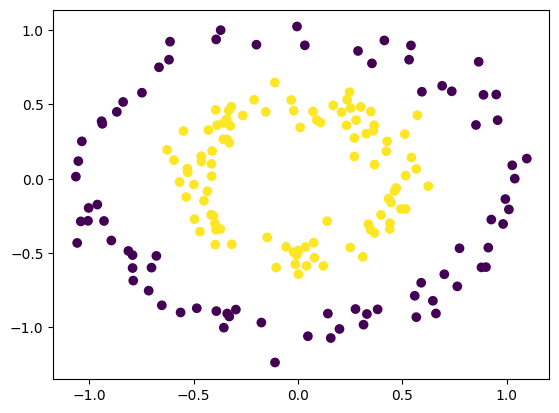

In [38]:
plt.scatter(X_test_c[:, 0], X_test_c[:, 1], c=y_pred, cmap='viridis');

## Part 4 : Training the shallow neural net on MNIST

### Load dataset

In [39]:
# This function taken directly from the Fashion-MNIST github site: 
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

# Note: first arg is the path name, second is the file prefix, either 'train' or 't10k' (which is 10k of test data)
def load_mnist(path, kind='train'): 
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [40]:
(train_imgs, train_labels) = load_mnist('./fashion-mnist-data', 'train')
(test_imgs, test_labels) = load_mnist('./fashion-mnist-data', 't10k')

In [41]:
label_names = ['T-shirt/top', 'Trouser' , 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [42]:
print(f"Shape of images is {train_imgs.shape}, labels is {train_labels.shape}")

Shape of images is (60000, 784), labels is (60000,)


#### Select the class

In [43]:
SELETCED_CLASS = ['Shirt', 'Sandal']
class1_index = label_names.index(SELETCED_CLASS[0])
class2_index = label_names.index(SELETCED_CLASS[1])


In [44]:
# Filter train data
train_indices = np.where((train_labels == class1_index) | (train_labels == class2_index))
train_imgs = train_imgs[train_indices]
train_labels = train_labels[train_indices]

# Filter test data
test_indices = np.where((test_labels == class1_index) | (test_labels == class2_index))
test_imgs = test_imgs[test_indices]
test_labels = test_labels[test_indices]

# Replace labels to 0 and 1 
train_labels[train_labels == class1_index] = 0
train_labels[train_labels == class2_index] = 1

test_labels[test_labels == class1_index] = 0
test_labels[test_labels == class2_index] = 1

unique_labels, counts = np.unique(train_labels, return_counts=True)
unique_labelst, countst = np.unique(test_labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} samples")

Label 0: 6000 samples
Label 1: 6000 samples


In [45]:
# Uncoment this section to select fewer sample
#num_samples_to_choose = 6000

# Generate random indices to select 500 samples
#random_indices = np.random.choice(train_imgs.shape[0], num_samples_to_choose, replace=False)

# Select the random samples from filtered training data
#train_imgs = train_imgs[random_indices]
#train_labels = train_labels[random_indices]

In [46]:
X_train_mnist_tot = train_imgs/255 # Normalising pixel to range 0 to 1
y_train_mnist_tot = train_labels

#### Train / Validation split

In [47]:
X_train_mnist, X_val_mnist, y_train_mnist, y_val_mnist = train_test_split(X_train_mnist_tot, y_train_mnist_tot, test_size=0.7, random_state=42)

In [48]:
J_list,W1,W2,b1,b2 = shallowNeuralNet(X_train_mnist,y_train_mnist,15,lr=0.01,eps = 1e-4)

epoch 1 J = 0.17002641241822647
epoch 2 J = 0.02904653392438015
epoch 3 J = 0.018580551649575703
epoch 4 J = 0.013503953559348896
epoch 5 J = 0.012836957866636736
epoch 6 J = 0.010660937851996118
epoch 7 J = 0.009622943395735911
epoch 8 J = 0.007117588726291719
epoch 9 J = 0.005451409435774899
epoch 10 J = 0.007151596302690082
epoch 11 J = 0.0057549499782165595
epoch 12 J = 0.005777192761813765
Training complete, convergence is reached after 12 epochs


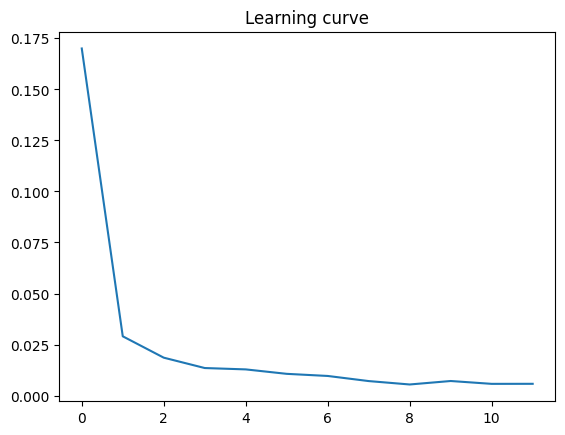

In [49]:
plt.plot(J_list)
plt.title("Learning curve");

Notes : 
- there is much more data than blob or circle so for the same number of iteration there is much less epoch

In [50]:
y_pred = predict_shallowNN(X_val_mnist,W1,W2,b1,b2)
acc = accuracy_score(y_pred,y_val_mnist)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.998


Experiment : 
- `n_nodes = 10,lr=0.01,eps = 1e-3`  --> 0.998, already very good !, lower eps
- `n_nodes = 10,lr=0.01,eps = 1e-4`  --> 0.998, not improving, increase number of nodes
- `n_nodes = 15,lr=0.01,eps = 1e-4` --> still 0.998

I choose the first model because same result for less training time and avoid overfitting

In [51]:
J_list,W1,W2,b1,b2 = shallowNeuralNet(X_train_mnist_tot,y_train_mnist_tot,10,lr=0.01,eps = 1e-3)

epoch 1 J = 0.07056169689211558
epoch 2 J = 0.011162163268499862
epoch 3 J = 0.007304668310684992
epoch 4 J = 0.0059700842748299735
epoch 5 J = 0.00579140527047859
Training complete, convergence is reached after 5 epochs


In [52]:
X_test_mnist = test_imgs/255
y_test_mnist = test_labels
y_pred = predict_shallowNN(X_test_mnist,W1,W2,b1,b2)
acc = accuracy_score(y_pred,y_test_mnist)
print(f'Accuracy score : {acc: .3f}')
cm = confusion_matrix(y_test_mnist, y_pred)
cm

Accuracy score :  0.999


array([[ 998,    2],
       [   0, 1000]])

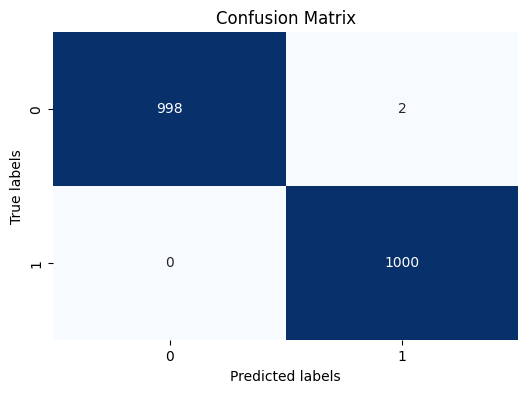

In [53]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Only two misclasified !

## Part 5 : Deep Neural Nett and Enhancement
### Deep neural net

First, let's focus on the implementation for any number of layer and any number of nodes for each layer. The algorithm stays similar to shallow neural net with the difference of computing forward pass and backward for each layer. 

Implementation details :
- I reused the previous code because it is again the same structure.  
- The challenging part for me is to find the right data structure not really for effeciency but rather for understanding and keep it close to the formulas.  
- I choosed to store every weight, z-value and a-value in a python list, where the index correspond to the layer. 
- For each layer l stored the corresponding parameter in a numpy array as before. 

The code bellow is showing how I initilised it with a for loop and then printing the shape for each layer to check wether it's right shape.  
The list `struct` is representing the structure of the network, the first item is the number of node of first layer and so on. 

In [84]:
## test for parameter initialisation
struct = [10,20,30,20,10] # An example of a deep structure
stopping = False
# initialize parameters
X = X_train_b

# First layer
W = [np.random.normal(size=(struct[0], X.shape[1]))]
b = [np.random.normal(size = (struct[0]))]
for i in range(len(struct)-1):
    W.append(np.random.normal(size=(struct[i+1],struct[i]))) # first index is next node, second index is current node
    b.append(np.random.normal(size=(struct[i+1])))

# Last layer
W.append(np.random.normal(size=(1,struct[-1])))
b.append(np.random.normal(size=(1)))
for i in range(len(W)):
    print(f"W{i} shape is {W[i].shape}")
    print(f"b{i} shape is {b[i].shape}")

print(f"number of layers :  {len(W)}")

W0 shape is (10, 3)
b0 shape is (10,)
W1 shape is (20, 10)
b1 shape is (20,)
W2 shape is (30, 20)
b2 shape is (30,)
W3 shape is (20, 30)
b3 shape is (20,)
W4 shape is (10, 20)
b4 shape is (10,)
W5 shape is (1, 10)
b5 shape is (1,)
number of layers :  6


Other implementation details : 
- We need to pay attention to the notation. Indeed a python list start at index 0 but the formulas start with layer 1 !
- This can lead to confusion espcecially because the formulas says $a^{[0]}$ correspond to `x`
- Therefore, I did the last backprop for the input layer outside the loop "manually" replacing $a^{[0]}$ by `x`
- Also, I did not use vectorisation AT ALL even for forward prop because it was more simple to understand and avoid any matrix multiplication error
- The algorithm is slower than the other because forward prop is done without vectorisation

In [55]:
def NeuralNet(X,Y,struct,lr = 0.001, max_iterations = 10000000,eps = 1e-4,nu = 0,sigma = 0.1):
    stopping = False
    # initialize parameters
    W = [np.random.normal(nu,sigma,size=(struct[0], X.shape[1]))]
    b = [np.random.normal(nu,sigma,size = (struct[0]))]
    for i in range(len(struct)-1):
        W.append(np.random.normal(nu,sigma,size=(struct[i+1],struct[i])))
        b.append(np.random.normal(nu,sigma,size=(struct[i+1])))
    W.append(np.random.normal(nu,sigma,size=(1,struct[-1])))
    b.append(np.random.normal(nu,sigma,size=(1)))

    N = len(X[:,1])
    N_layer = len(W)
    J_running = 0
    J_running_prev = 0
    iteration = 0 
    J_list = []
    epoch = 0

    while not stopping: 
        i = rd.randint(0,N-1)
        x,y = X[i],Y[i]
        z = [0] * N_layer
        a = [0] * N_layer
        
        # forward propagation 

        # First layer

        n_nodes_1 = W[0].shape[0]  
        n_nodes_input = W[0].shape[1]

        z[0] = np.zeros(shape=(n_nodes_1))
        a[0] = np.zeros(shape=(n_nodes_1))

        
        for i in range(n_nodes_1):
            z[0][i] = sum([W[0][i,j] * x[j] for j in range(n_nodes_input)]) + b[0][i]
        for i in range(n_nodes_1):
            a[0][i] = sigmoid(z[0][i])
    
        for l in range(1,N_layer):
            n_nodes = W[l].shape[0] # number of node of current layer l
            n_nodes_before = W[l-1].shape[0] #number of node of layer l-1
            
            z[l] = np.zeros(shape=(n_nodes))
            a[l] = np.zeros(shape=(n_nodes))
            
            for i in range(n_nodes):
                z[l][i] = sum([W[l][i,j] * a[l-1][j] for j in range(n_nodes_before)]) + b[l][i]
            for i in range(n_nodes):
                a[l][i] = sigmoid(z[l][i])



        y_hat = a[-1][0]
        J_current = - (y*np.log(y_hat + 1e-8) + (1-y)*np.log(1-y_hat + 1e-8))
    

        # Backward Propagation 
        DZ = [0] * N_layer
        DW = [0] * N_layer
        DB = [0] * N_layer

        # Output layer
        DZ[-1] = np.array([y_hat - y])
        DW[-1] = DZ[-1] * a[N_layer-2]
        DB[-1] = DZ[-1]


        # hidden layer
        for l in range(N_layer-2,0,-1): # loop backward
            n_nodes = W[l].shape[0] # number of node of current layer l
            n_nodes_next = W[l+1].shape[0] # number of node of layer l + 1
            n_nodes_before = W[l-1].shape[0] # number of node of layer l - 1
            
            # DZ 
            DZ[l] = np.zeros(shape=(n_nodes))
            for i in range(n_nodes):
                DZ[l][i] = dsigmoid(z[l][i]) * sum([DZ[l+1][j] * W[l+1][j,i] for j in range(n_nodes_next)])
    
            # DW and DB
            DW[l] = np.zeros(shape=(n_nodes,n_nodes_before))
            DB[l] = np.zeros(shape=(n_nodes))
            for j in range(n_nodes):
                DB[l][j] = DZ[l][j]
                for i in range(n_nodes_before):
                    DW[l][j,i] = DZ[l][j] * a[l-1][i]

        # First layer
          
        n_nodes = W[0].shape[0] # number of node of current layer 0
        n_nodes_next = W[1].shape[0] # number of node of layer 1
        n_nodes_before = W[0].shape[1] # Input layer size

        DZ[0] = np.zeros(shape=(n_nodes))
        for i in range(n_nodes):
            DZ[0][i] = dsigmoid(z[0][i]) * sum([DZ[1][j] * W[1][j,i] for j in range(n_nodes_next)])
        DW[0] = np.zeros(shape=(n_nodes,n_nodes_before))
        DB[0] = np.zeros(shape=(n_nodes))

        for j in range(n_nodes):
            DB[0][j] = DZ[0][j]
            for i in range(n_nodes_before):
                DW[0][j,i] = DZ[0][j] * x[i]
            

        #Gradient descent 
        for l in range(len(W)):
            W[l] -= lr*DW[l]
            b[l] -= lr*DB[l]

        iteration += 1
        J_running += J_current
        if iteration > max_iterations: stopping = True 
        if (iteration % N) == 0: 
            epoch += 1
            J_running = J_running / N
            J_list.append(J_running)
            if abs(J_running - J_running_prev) < eps : stopping = True
            print(f'epoch {epoch} J = {J_running}')
            J_running_prev = J_running
            J_running = 0
            

    # Print wether the convergence is reached or not
    if iteration == max_iterations + 1:
        print("max iteration reached, convergence is not reached you may need to adjust parameters")
    else : 
        print(f"Training complete, convergence is reached after {epoch} epochs")
    return (J_list,W,b)              
                           
                

In [56]:
def predict_NN(X,W,b):
    N_layer = len(W)
    z = [0] * N_layer
    a = [0] * N_layer
    y_pred = []
    for i in range(len(X[:,1])):
        x = X[i]
        n_nodes_1 = W[0].shape[0]  
        n_nodes_input = W[0].shape[1]

        z[0] = np.zeros(shape=(n_nodes_1))
        a[0] = np.zeros(shape=(n_nodes_1))

        
        for i in range(n_nodes_1):
            z[0][i] = sum([W[0][i,j] * x[j] for j in range(n_nodes_input)]) + b[0][i]
        for i in range(n_nodes_1):
            a[0][i] = sigmoid(z[0][i])
    
        for l in range(1,N_layer):
            n_nodes = W[l].shape[0] # number of node of current layer l
            n_nodes_before = W[l-1].shape[0] #number of node of layer l-1
            
            z[l] = np.zeros(shape=(n_nodes))
            a[l] = np.zeros(shape=(n_nodes))
            
            for i in range(n_nodes):
                z[l][i] = sum([W[l][i,j] * a[l-1][j] for j in range(n_nodes_before)]) + b[l][i]
            for i in range(n_nodes):
                a[l][i] = sigmoid(z[l][i])

        y_hat = a[-1][0]
        y_pred.append(y_hat)

    y_pred_binary = [1 if y > 0.5 else 0 for y in y_pred]
    return y_pred_binary
        
    

#### Test on MNIST

In [57]:
struct = [10,5]
J_list,W,b = NeuralNet(X_train_mnist,y_train_mnist,struct,lr=0.01,eps =1e-3)

epoch 1 J = 0.6940286204582986
epoch 2 J = 0.6861260208071058
epoch 3 J = 0.40612531108505756
epoch 4 J = 0.06612701222222955
epoch 5 J = 0.03642118020029887
epoch 6 J = 0.02538012940400198
epoch 7 J = 0.018669862018739887
epoch 8 J = 0.01416231479533701
epoch 9 J = 0.010330111003686446
epoch 10 J = 0.009786781464844522
Training complete, convergence is reached after 10 epochs


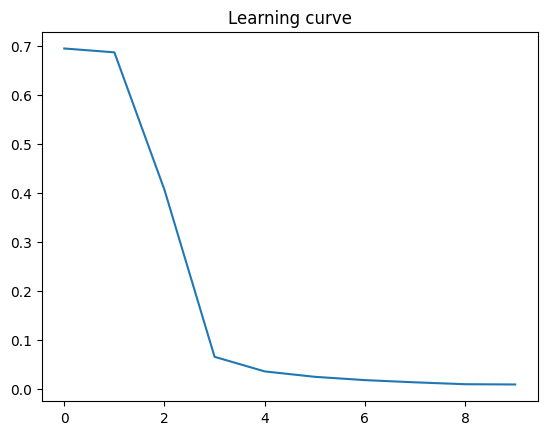

In [58]:
plt.plot(J_list)
plt.title("Learning curve");

In [59]:
y_pred = predict_NN(X_val_mnist,W,b)
acc = accuracy_score(y_pred,y_val_mnist)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.998


Experiment : 
- `struct = [10,3], lr=0.01,eps =1e-3` --> 0.997 
- `struct = [10,5], lr=0.01,eps =1e-3` --> 0.998

I will choose the last structure

In [60]:
J_list,W,b = NeuralNet(X_train_mnist_tot,y_train_mnist_tot,[10,5],lr=0.01,eps =1e-3)

epoch 1 J = 0.3925801702160498
epoch 2 J = 0.020826060825126714
epoch 3 J = 0.012380960948087357
epoch 4 J = 0.008285517228047753
epoch 5 J = 0.004674409269252806
epoch 6 J = 0.006470774612729988
epoch 7 J = 0.0057553596273605965
Training complete, convergence is reached after 7 epochs


In [61]:
y_pred = predict_NN(X_test_mnist,W,b)
acc = accuracy_score(y_pred,y_test_mnist)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  1.000


Accuracy of 1 on test set !

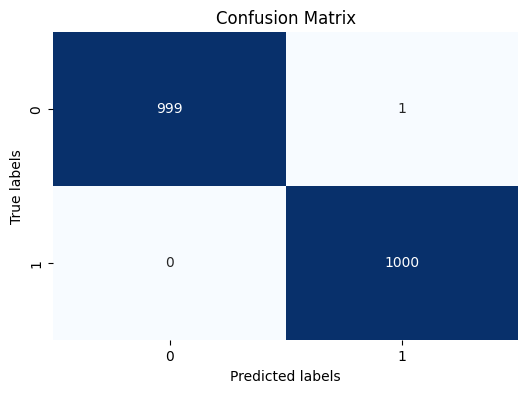

In [62]:
cm = confusion_matrix(y_test_mnist, y_pred)
cm
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Enhancement

I had to choose one enhancement in the following list : 
- Multi class problem
- Mini Batch GD
- L1 or L2 Regularisation
- Early stopping
- gradient descent with momentum or RMSprop
- Adam Optimizer

The enhancement I choosed is multi class to solve mnist for all classes. 
Difference in the code : 
- The input label y need to be encoded in a vector enc_y where `enc_y[i] = 1` if `y = 1` and `0` for the rest
- The parameter in the output does not have the same size it's `(N_class,n_nodes)` instead of `(1,n_nodes)`
- Last layer activation function is softmax and not sigmoid
- The back prop in the last layer change a little bit because of the soft max function. 
- The derivative of J with respcect to $z^{[L]}$ is now a vector $(\hat{y} - y)$
- The rest stay the same


In [63]:
def softmax(z):
    s = sum([np.exp(z[i]) for i in range(len(z))])
    return np.exp(z)/s

In [64]:
#test of softmax
softmax(np.array([0,1.4,0.5,0.6]))

array([0.11728774, 0.47562525, 0.1933748 , 0.2137122 ])

In [65]:
def NeuralNet_bis(X,Y,struct,lr = 0.001, max_iterations = 1000000,eps = 1e-4,nu = 0,sigma=0.1):
    
    N = len(X[:,1])
    J_running = 0
    J_running_prev = 0
    iteration = 0 
    J_list = []
    epoch = 0
    class_name = np.unique(Y)
    N_class = len(class_name) # number of class
    stopping = False

    # initialize parameters
    W = [np.random.normal(nu,sigma,size=(struct[0], X.shape[1]))]
    b = [np.random.normal(nu,sigma,size = (struct[0]))]
    for i in range(len(struct)-1):
        W.append(np.random.normal(nu,sigma,size=(struct[i+1],struct[i])))
        b.append(np.random.normal(nu,sigma,size=(struct[i+1])))

    W.append(np.random.normal(nu,sigma,size=(N_class,struct[-1]))) # change here because last layer has N_class nodes
    b.append(np.random.normal(nu,sigma,size=(N_class)))
    N_layer = len(W)


    while not stopping: 
        i = rd.randint(0,N-1)
        x,y = X[i],Y[i]


        # Encoding the class number to a one hot vector
        enc_y = [0] * N_class
        enc_y[y] = 1
        enc_y = np.array(enc_y)


        z = [0] * N_layer
        a = [0] * N_layer
        
        # forward propagation 

        # First layer
        n_nodes_1 = W[0].shape[0]  
        n_nodes_input = W[0].shape[1]

        z[0] = np.zeros(shape=(n_nodes_1))
        a[0] = np.zeros(shape=(n_nodes_1))

        
        for i in range(n_nodes_1):
            z[0][i] = sum([W[0][i,j] * x[j] for j in range(n_nodes_input)]) + b[0][i]
        for i in range(n_nodes_1):
            a[0][i] = sigmoid(z[0][i])
    
        for l in range(1,N_layer-1):
            n_nodes = W[l].shape[0] # number of node of current layer l
            n_nodes_before = W[l-1].shape[0] #number of node of layer l-1
            
            z[l] = np.zeros(shape=(n_nodes))
            a[l] = np.zeros(shape=(n_nodes))
            

            for i in range(n_nodes):
                z[l][i] = sum([W[l][i,j] * a[l-1][j] for j in range(n_nodes_before)]) + b[l][i]
            for i in range(n_nodes):
                a[l][i] = sigmoid(z[l][i])


        z[-1] = np.zeros(shape=(N_class))
        for i in range(N_class):
            z[-1][i] = sum([W[-1][i,j] * a[-2][j] for j in range(struct[-1])]) + b[-1][i]
        a[-1] = softmax(z[-1])
        y_hat = a[-1]
        J_current = - sum([enc_y[i] * np.log(y_hat[i]) for i in range(N_class)])
    

        # Backward Propagation 
        DZ = [0] * N_layer
        DW = [0] * N_layer
        DB = [0] * N_layer

        # Output layer
        DZ[-1] = np.zeros(shape=(N_class))
        for j in range(N_class):
            DZ[-1][j] = a[-1][j] - enc_y[j]

        
        DW[-1] = np.zeros(shape=(N_class,struct[-1]))
        DB[-1] = np.zeros(shape=(N_class))
        for j in range(N_class):
            DB[-1][j] = DZ[-1][j]
            for i in range(struct[-1]):
                DW[-1][j,i] = DZ[-1][j] * a[N_layer-2][i]
        
        # hidden layer
        for l in range(N_layer-2,0,-1): 
            n_nodes = W[l].shape[0] # number of node of current layer l
            n_nodes_next = W[l+1].shape[0] # number of node of layer l + 1
            n_nodes_before = W[l-1].shape[0] # number of node of layer l - 1
            
            # DZ 
            DZ[l] = np.zeros(shape=(n_nodes))
            for i in range(n_nodes):
                DZ[l][i] = dsigmoid(z[l][i]) * sum([DZ[l+1][j] * W[l+1][j,i] for j in range(n_nodes_next)])

            # DW and DB
            DW[l] = np.zeros(shape=(n_nodes,n_nodes_before))
            DB[l] = np.zeros(shape=(n_nodes))
            for j in range(n_nodes):
                DB[l][j] = DZ[l][j]
                for i in range(n_nodes_before):
                    DW[l][j,i] = DZ[l][j] * a[l-1][i]

        # First layer
          
        n_nodes = W[0].shape[0] # number of node of current layer 0
        n_nodes_next = W[1].shape[0] # number of node of layer 1
        n_nodes_before = W[0].shape[1] # Input layer size

        DZ[0] = np.zeros(shape=(n_nodes))
        for i in range(n_nodes):
            DZ[0][i] = dsigmoid(z[0][i]) * sum([DZ[1][j] * W[1][j,i] for j in range(n_nodes_next)])
        DW[0] = np.zeros(shape=(n_nodes,n_nodes_before))
        DB[0] = np.zeros(shape=(n_nodes))
        
        for j in range(n_nodes):
            DB[0][j] = DZ[0][j]
            for i in range(n_nodes_before):
                DW[0][j,i] = DZ[0][j] * x[i]
            
        #Gradient descent 
        for l in range(len(W)):
            W[l] -= lr*DW[l]
            b[l] -= lr*DB[l]

        iteration += 1
        J_running += J_current
        if iteration > max_iterations: stopping = True 
        if (iteration % N) == 0: 
            epoch += 1
            J_running = J_running / N
            J_list.append(J_running)
            if abs(J_running - J_running_prev) < eps : stopping = True
            print(f'epoch {epoch} J = {J_running}')
            J_running_prev = J_running
            J_running = 0
            

    # Print wether the convergence is reached or not
    if iteration == max_iterations + 1:
        print("max iteration reached, convergence is not reached you may need to adjust parameters")
    else : 
        print(f"Training complete, convergence is reached after {epoch} epochs")
    return (J_list,W,b)              
                           
                

In [66]:
def predict_NN_bis(X,W,b):
    N_layer = len(W)
    z = [0] * N_layer
    a = [0] * N_layer
    y_pred = []
    N_class = W[-1].shape[0]
    for i in range(len(X[:,1])):
        x = X[i]
        n_nodes_1 = W[0].shape[0]  
        n_nodes_input = W[0].shape[1]

        z[0] = np.zeros(shape=(n_nodes_1))
        a[0] = np.zeros(shape=(n_nodes_1))

        
        for i in range(n_nodes_1):
            z[0][i] = sum([W[0][i,j] * x[j] for j in range(n_nodes_input)]) + b[0][i]
        for i in range(n_nodes_1):
            a[0][i] = sigmoid(z[0][i])
    
        for l in range(1,N_layer-1):
            n_nodes = W[l].shape[0] # number of node of current layer l
            n_nodes_before = W[l-1].shape[0] #number of node of layer l-1
            
            z[l] = np.zeros(shape=(n_nodes))
            a[l] = np.zeros(shape=(n_nodes))
            

            for i in range(n_nodes):
                z[l][i] = sum([W[l][i,j] * a[l-1][j] for j in range(n_nodes_before)]) + b[l][i]
            for i in range(n_nodes):
                a[l][i] = sigmoid(z[l][i])
        z[-1] = np.zeros(shape=(N_class))
        for i in range(N_class):
            z[-1][i] = sum([W[-1][i,j] * a[-2][j] for j in range(struct[-1])]) + b[-1][i]
        a[-1] = softmax(z[-1])
        y_hat = a[-1]

        y_hat = a[-1]
        y_pred.append(y_hat)

    y_pred_final = [np.argmax(y) for y in y_pred]
    return y_pred_final

## Part 6 : Test of the multiclass algorithm on MNIST
### Testing only 2 classes

In [67]:
struct = [10,3]
J_list,W,b = NeuralNet_bis(X_train_mnist,y_train_mnist,struct,lr=0.01,eps =1e-3)

epoch 1 J = 0.6936101112115229
epoch 2 J = 0.475515198188348
epoch 3 J = 0.06268223629238132
epoch 4 J = 0.031665012737209404
epoch 5 J = 0.017890346287355505
epoch 6 J = 0.02064335756808725
epoch 7 J = 0.010921473611890366
epoch 8 J = 0.011389643644889357
Training complete, convergence is reached after 8 epochs


Still working !

### Testing with all 9 classes

In [68]:
# Reload the whole dataset
(train_imgs, train_labels) = load_mnist('./fashion-mnist-data', 'train')
(test_imgs, test_labels) = load_mnist('./fashion-mnist-data', 't10k')

In [69]:
num_samples_to_choose = 10000 


random_indices = np.random.choice(train_imgs.shape[0], num_samples_to_choose, replace=False)

# Select the random samples from filtered training data
train_imgs = train_imgs[random_indices]
train_labels = train_labels[random_indices]

Notes : I did not stratified the so the number of sample for each class is random. One improvement could be making sure that each class has the same number of sample

In [70]:
X_train_mnist_multi_tot = train_imgs/255
y_train_mnist_multi_tot = train_labels

X_train_mnist_multi, X_val_mnist_multi, y_train_mnist_multi, y_val_mnist_multi = train_test_split(X_train_mnist_multi_tot, y_train_mnist_multi_tot, test_size=0.7, random_state=42)

In [71]:
struct = [10,5]
J_list,W,b = NeuralNet_bis(X_train_mnist_multi,y_train_mnist_multi,struct,lr=0.01,eps =1e-3,sigma = 0.1)

epoch 1 J = 2.305927451099292
epoch 2 J = 2.2981901697262668
epoch 3 J = 2.2569325650403154
epoch 4 J = 2.0078308496502597
epoch 5 J = 1.7625437906096844
epoch 6 J = 1.5897087969512513
epoch 7 J = 1.467165537438684
epoch 8 J = 1.3824586790192754
epoch 9 J = 1.3152957258782665
epoch 10 J = 1.2492574711168227
epoch 11 J = 1.156868205506037
epoch 12 J = 1.0727859779281532
epoch 13 J = 1.0382184637941587
epoch 14 J = 1.0017761259682885
epoch 15 J = 0.9661134802521528
epoch 16 J = 0.9236265119288106
epoch 17 J = 0.8812058603181697
epoch 18 J = 0.8488225460247494
epoch 19 J = 0.8092971694082199
epoch 20 J = 0.7957424037276127
epoch 21 J = 0.7680271590305929
epoch 22 J = 0.7273465085183209
epoch 23 J = 0.7116374094982927
epoch 24 J = 0.6801482619486565
epoch 25 J = 0.6856012808179294
epoch 26 J = 0.6595733519258933
epoch 27 J = 0.6363627485739721
epoch 28 J = 0.6239964179818331
epoch 29 J = 0.6088356235267927
epoch 30 J = 0.5849327478768307
epoch 31 J = 0.5690696401551
epoch 32 J = 0.56756569

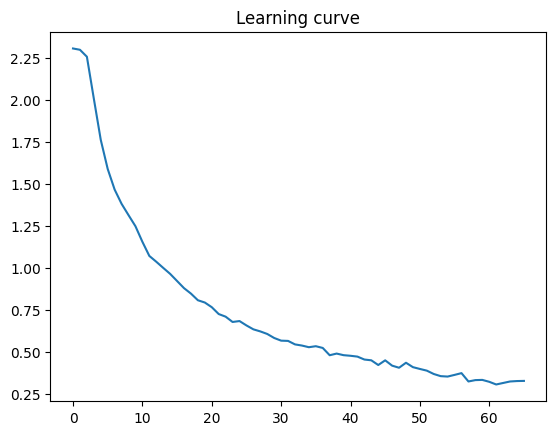

In [72]:
plt.plot(J_list)
plt.title("Learning curve");

In [73]:
y_pred = predict_NN_bis(X_val_mnist_multi,W,b)
acc = accuracy_score(y_pred,y_val_mnist_multi)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.797


Experiment : 
- `struct = [10,5],lr=0.01,eps =1e-3` --> 0.75 Training was 10 minutes long so I will not do a lot of experiment. Maybe I will try to add a third layer
- 'struct = [10,5,10],lr=0.01,eps =1e-3' --> very bad result the algorithm converges after 2 epochs with no improvement
- 'struct = [10,5,3],lr=0.01,eps =1e-3,sigma = 1' --> I changed sigma and I obtained better results but still not as good as the first one

I will keep the first setting for testing

In [74]:
J_list,W,b = NeuralNet_bis(X_train_mnist_multi_tot,y_train_mnist_multi_tot,[10,5],lr=0.01,eps =1e-3)

epoch 1 J = 2.1909936349371195
epoch 2 J = 1.602347535603032
epoch 3 J = 1.2943909443917863
epoch 4 J = 1.1283967347965795
epoch 5 J = 1.0196102362787098
epoch 6 J = 0.9169154849079909
epoch 7 J = 0.840712570872699
epoch 8 J = 0.7717405360859502
epoch 9 J = 0.7038494953467886
epoch 10 J = 0.6635637558955002
epoch 11 J = 0.6328517259473257
epoch 12 J = 0.586425551280212
epoch 13 J = 0.5850560337144327
epoch 14 J = 0.5577840941108164
epoch 15 J = 0.5235431155374886
epoch 16 J = 0.5029219940931272
epoch 17 J = 0.47823330050586227
epoch 18 J = 0.4721610992509217
epoch 19 J = 0.4617511642192707
epoch 20 J = 0.4630723383334549
epoch 21 J = 0.45502596663121603
epoch 22 J = 0.4323571840375469
epoch 23 J = 0.419788465440353
epoch 24 J = 0.419280069902965
Training complete, convergence is reached after 24 epochs


In [77]:
X_test_mnist_multi = test_imgs/255
y_test_mnist_multi = test_labels

y_pred = predict_NN_bis(X_test_mnist_multi,W,b)
acc = accuracy_score(y_pred,y_test_mnist_multi)
print(f'Accuracy score : {acc: .3f}')

Accuracy score :  0.806


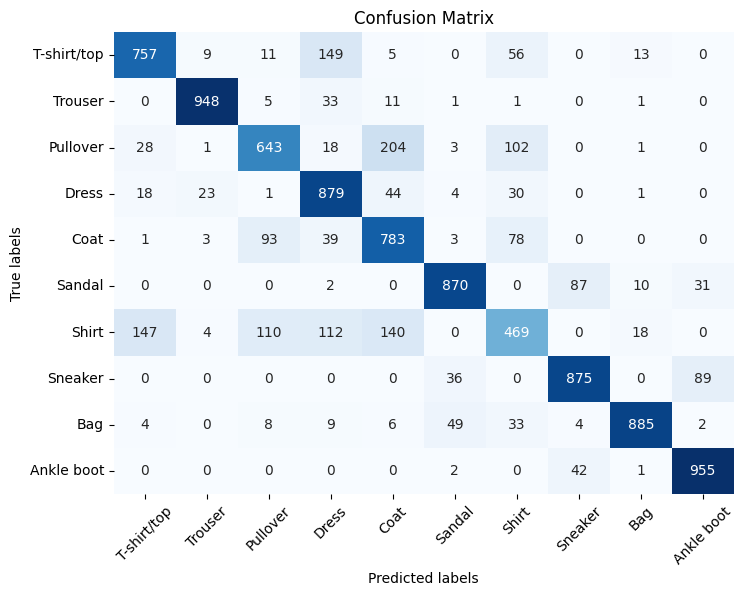

In [79]:
cm = confusion_matrix(y_test_mnist_multi, y_pred)
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks + 0.5, label_names, rotation=45)
plt.yticks(tick_marks + 0.5, label_names, rotation=0)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

plt.show()
